In [1]:
from collections import ChainMap

from joblib import Parallel
from joblib import delayed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from util import load_data, fdr, fdr_prob

In [2]:
x_train, x_test, x_oot, y_train, y_test, y_oot = load_data('var_30.csv')
x_train.head()

,ssn_count_3,fulladdress_count_0,address_count_0,name_dob_count_3,homephone_count_14,name_dob_count_7,name_day_since,ssn_firstname_count_0_by_14,name_count_7,fulladdress_homephone_count_0_by_14,...,ssn_count_0_by_14,ssn_firstname_count_7,ssn_count_7,fulladdress_count_1_by_14,fulladdress_homephone_count_7,ssn_name_dob_count_7,name_count_14,ssn_firstname_count_0_by_30,ssn_lastname_count_0_by_30,ssn_count_14
138958,-0.047591,-0.041351,-0.042158,-0.046415,-0.437943,-0.055801,0.598116,0.123528,-0.115648,0.120387,...,0.124781,-0.057185,-0.058092,0.123861,-0.057263,-0.055635,-0.159376,0.171472,0.171458,-0.072421
299997,-0.047591,-0.041351,-0.042158,-0.046415,0.708788,-0.055801,0.598116,0.123528,-0.115648,0.120387,...,0.124781,-0.057185,-0.058092,0.123861,-0.057263,-0.055635,-0.159376,0.171472,0.171458,-0.072421
394380,-0.047591,-0.041351,-0.042158,-0.046415,0.135423,-0.055801,0.598116,0.123528,-0.115648,0.120387,...,0.124781,-0.057185,-0.058092,0.123861,-0.057263,-0.055635,-0.159376,0.171472,0.171458,-0.072421
647058,-0.047591,-0.041351,-0.042158,-0.046415,-0.437943,-0.055801,-2.009893,0.123528,-0.115648,0.120387,...,0.124781,-0.057185,-0.058092,0.123861,-0.057263,-0.055635,-0.159376,0.171472,0.171458,-0.072421
285351,-0.047591,-0.041351,-0.042158,-0.046415,-1.011308,-0.055801,0.598116,0.123528,-0.115648,0.120387,...,0.124781,-0.057185,-0.058092,0.123861,-0.057263,-0.055635,-0.159376,0.171472,0.171458,-0.072421


In [4]:
dt = DecisionTreeClassifier(ccp_alpha=1e-06, 
                            max_depth=20,
                            min_samples_leaf=64, 
                            class_weight=None,
                            criterion='gini').fit(x_train, y_train)
dt_train_score = fdr(dt, x_train, y_train)
dt_test_score = fdr(dt, x_test, y_test)

In [5]:
def fit_and_calculate_fdr(original_param, setting, label, color):
    params = ChainMap(setting, original_param)
    ada = AdaBoostClassifier(**params).fit(x_train, y_train)
    test_score = [fdr_prob(y_test, y_pred_prob)
                  for y_pred_prob in ada.staged_predict_proba(x_test)]
    return label, color, test_score

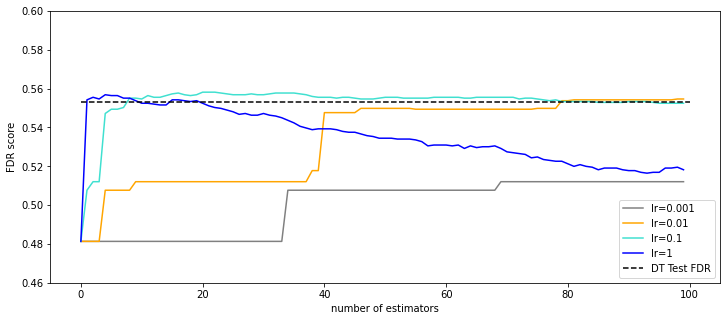

In [7]:
original_param = {'base_estimator': DecisionTreeClassifier(max_depth=5),
                  'n_estimators': 100, 'algorithm': 'SAMME.R'}

test_scores = Parallel(n_jobs=-1, verbose=1, prefer='processes')(
    delayed(fit_and_calculate_fdr)(original_param, setting, label, color)
    for label, color, setting in [
        ('lr=0.001', 'gray', {'learning_rate': 0.001}),
        ('lr=0.01', 'orange', {'learning_rate': 0.01}),
        ('lr=0.1', 'turquoise', {'learning_rate': 0.1}),
        ('lr=1', 'blue', {'learning_rate': 1})]
)

plt.figure(figsize=(12, 5))
for label, color, test_score in test_scores:
    plt.plot(range(original_param['n_estimators']), test_score,
             '-', color=color, label=label)
plt.plot([0, original_param['n_estimators']],
         [dt_test_score] * 2, 'k--', label='DT Test FDR')
plt.ylim((0.46, 0.6))
plt.xlabel('number of estimators')
plt.ylabel('FDR score')
plt.legend(loc='lower right')
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.4min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished


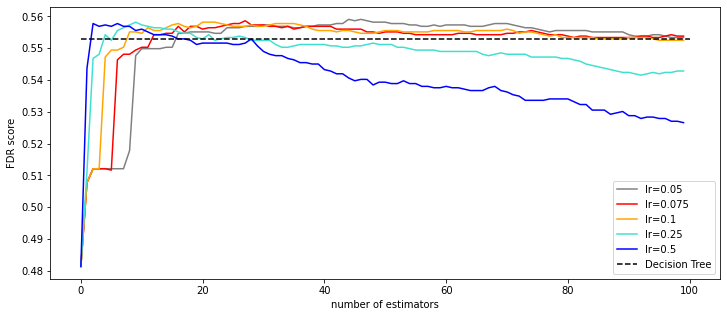

In [8]:
original_param = {'base_estimator': DecisionTreeClassifier(max_depth=5),
                  'n_estimators': 100, 'algorithm': 'SAMME.R'}

test_scores = Parallel(n_jobs=-1, verbose=1, prefer='processes')(
    delayed(fit_and_calculate_fdr)(original_param, setting, label, color)
    for label, color, setting in [
        ('lr=0.05', 'gray', {'learning_rate': 0.05}),
        ('lr=0.075', 'red', {'learning_rate': 0.075}),
        ('lr=0.1', 'orange', {'learning_rate': 0.1}),
        ('lr=0.25', 'turquoise', {'learning_rate': 0.25}),
        ('lr=0.5', 'blue', {'learning_rate': 0.5})]
)

plt.figure(figsize=(12, 5))
for label, color, test_score in test_scores:
    plt.plot(range(original_param['n_estimators']), test_score,
             '-', color=color, label=label)
plt.plot([0, original_param['n_estimators']],
         [dt_test_score] * 2, 'k--', label='Decision Tree')
plt.xlabel('number of estimators')
plt.ylabel('FDR score')
plt.legend(loc='lower right')
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.0min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


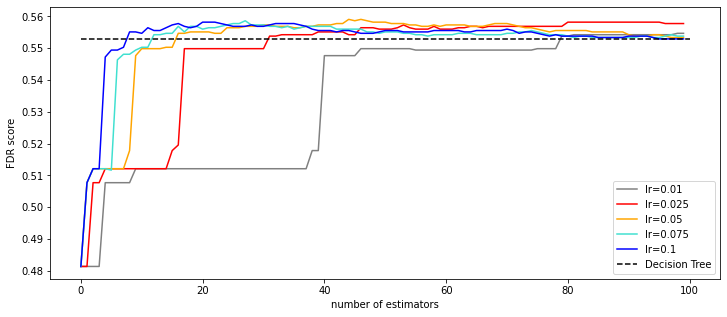

In [10]:
original_param = {'base_estimator': DecisionTreeClassifier(max_depth=5),
                  'n_estimators': 100, 'algorithm': 'SAMME.R'}

test_scores = Parallel(n_jobs=-1, verbose=1, prefer='processes')(
    delayed(fit_and_calculate_fdr)(original_param, setting, label, color)
    for label, color, setting in [
        ('lr=0.01', 'gray', {'learning_rate': 0.01}),
        ('lr=0.025', 'red', {'learning_rate': 0.025}),
        ('lr=0.05', 'orange', {'learning_rate': 0.05}),
        ('lr=0.075', 'turquoise', {'learning_rate': 0.075}),
        ('lr=0.1', 'blue', {'learning_rate': 0.1})]
)

plt.figure(figsize=(12, 5))
for label, color, test_score in test_scores:
    plt.plot(range(original_param['n_estimators']), test_score,
             '-', color=color, label=label)
plt.plot([0, original_param['n_estimators']],
         [dt_test_score] * 2, 'k--', label='Decision Tree')
plt.xlabel('number of estimators')
plt.ylabel('FDR score')
plt.legend(loc='lower right')
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   53.3s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


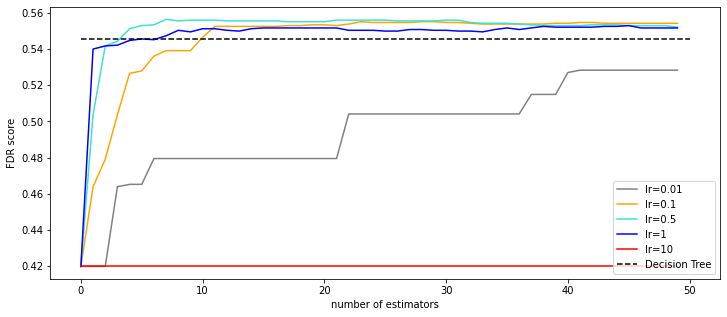

In [7]:
# if max_depth = 3
original_param = {'base_estimator': DecisionTreeClassifier(max_depth=3),
                  'n_estimators': 50, 'algorithm': 'SAMME.R'}

test_scores = Parallel(n_jobs=-1, verbose=1, prefer='processes')(
    delayed(fit_and_calculate_fdr)(original_param, setting, label, color)
    for label, color, setting in [
        ('lr=0.01', 'gray', {'learning_rate': 0.01}),
        ('lr=0.1', 'orange', {'learning_rate': 0.1}),
        ('lr=0.5', 'turquoise', {'learning_rate': 0.5}),
        ('lr=1', 'blue', {'learning_rate': 1}),
        ('lr=10', 'red', {'learning_rate': 10})]
)

plt.figure(figsize=(12, 5))
for label, color, test_score in test_scores:
    plt.plot(range(original_param['n_estimators']), test_score,
             '-', color=color, label=label)
plt.plot([0, original_param['n_estimators']],
         [dt_test_score] * 2, 'k--', label='Decision Tree')
plt.xlabel('number of estimators')
plt.ylabel('FDR score')
plt.legend(loc='lower right')
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.4min finished


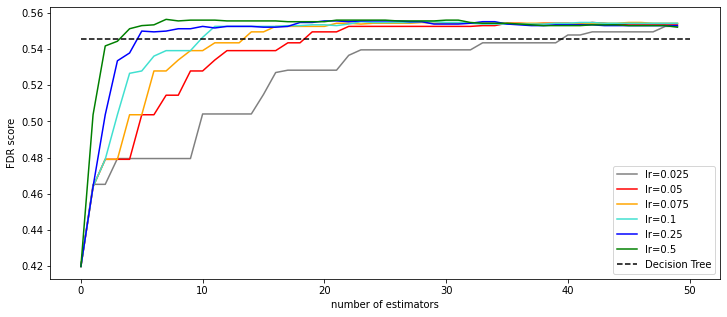

In [8]:
# if max_depth = 3
original_param = {'base_estimator': DecisionTreeClassifier(max_depth=3),
                  'n_estimators': 50, 'algorithm': 'SAMME.R'}

test_scores = Parallel(n_jobs=-1, verbose=1, prefer='processes')(
    delayed(fit_and_calculate_fdr)(original_param, setting, label, color)
    for label, color, setting in [
        ('lr=0.025', 'gray', {'learning_rate': 0.025}),
        ('lr=0.05', 'red', {'learning_rate': 0.05}),
        ('lr=0.075', 'orange', {'learning_rate': 0.075}),
        ('lr=0.1', 'turquoise', {'learning_rate': 0.1}),
        ('lr=0.25', 'blue', {'learning_rate': 0.25}),
        ('lr=0.5', 'green', {'learning_rate': 0.5})]
)

plt.figure(figsize=(12, 5))
for label, color, test_score in test_scores:
    plt.plot(range(original_param['n_estimators']), test_score,
             '-', color=color, label=label)
plt.plot([0, original_param['n_estimators']],
         [dt_test_score] * 2, 'k--', label='Decision Tree')
plt.xlabel('number of estimators')
plt.ylabel('FDR score')
plt.legend(loc='lower right')
plt.show()

In [9]:
x_train, _, x_oot, y_train, _, y_oot = load_data('var_30.csv', test_size=0)
x_train.head()
x_train = x_train.to_numpy()

In [10]:
labels = []
train_scores = []
test_scores = []

In [12]:
def add_score(n_estimators, learning_rate, max_depth, x_train, y_train):
    ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth),
                             learning_rate=learning_rate,
                             n_estimators=n_estimators,
                             algorithm='SAMME.R')
    score = cross_validate(ada, x_train, y_train, 
                           scoring=fdr, cv=16, n_jobs=8, verbose=1,
                           return_train_score=True)

    train_scores.append(score['train_score'])
    test_scores.append(score['test_score'])
    labels.append(f"N={n_estimators},lr={learning_rate},depth={max_depth}")
    print(np.mean(score['test_score']))

In [13]:
add_score(100, 0.025, 5, x_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


0.548465829846583


[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed: 15.7min finished


In [ ]:
add_score(50, 0.05, 5, x_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
add_score(25, 0.075, 5, x_train, y_train)

In [ ]:
add_score(50, 0.1, 3, x_train, y_train)

In [ ]:
add_score(15, 0.5, 3, x_train, y_train)

In [19]:
pd.DataFrame(test_scores, index=labels).mean(numeric_only=True, axis=1)

N=100,lr=0.025,depth=5    0.548466
N=50,lr=0.05,depth=5      0.548204
N=25,lr=0.075,depth=5     0.547594
N=50,lr=0.1,depth=3       0.549250
N=15,lr=0.5,depth=3       0.548030
dtype: float64

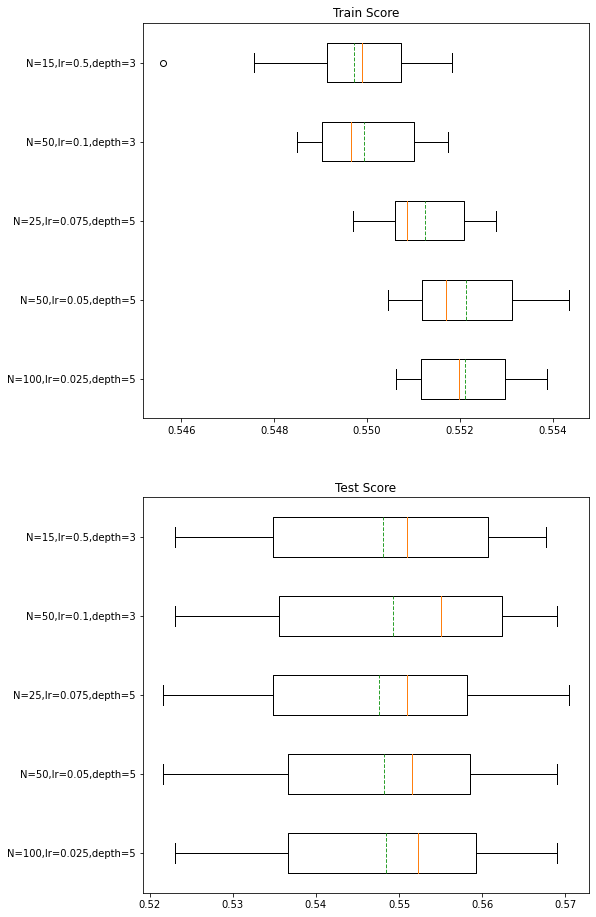

In [23]:
train_stats = cbook.boxplot_stats(train_scores, labels=labels)
test_stats = cbook.boxplot_stats(test_scores, labels=labels)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 16))
ax[0].bxp(train_stats, showfliers=True, meanline=True, showmeans=True, vert=False)
ax[0].set_title('Train Score')
ax[1].bxp(test_stats, showfliers=True, meanline=True, showmeans=True, vert=False)
ax[1].set_title('Test Score')
plt.show()